In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from fastmeteo import Grid

from traffic.core import Traffic, Flight

import warnings
warnings.filterwarnings("ignore")


In [2]:
t = Traffic.from_file("data/eham_flights_benchmark.csv.gz", parse_dates=True)
t = t.assign(timestamp = pd.to_datetime(t.data.timestamp).dt.tz_convert(None))

In [4]:
# define the location for local store
fmg = Grid(local_store="/tmp/era5-zarr")

In [4]:
for dt in [5, 10, 20, 30, 60, 120, 180, 300, 600]:
    t_ = t.assign_id().filter().resample(f"{dt}s").eval(16)
    print(t_.data.shape)
    %time df_new = fmg.interpolate(t_.data)

(935765, 13)
CPU times: user 19.2 s, sys: 26.4 s, total: 45.6 s
Wall time: 6.98 s
(468240, 13)
CPU times: user 18.8 s, sys: 25.9 s, total: 44.7 s
Wall time: 6.06 s
(234473, 13)
CPU times: user 18 s, sys: 25.2 s, total: 43.2 s
Wall time: 5.34 s
(156553, 13)
CPU times: user 17.6 s, sys: 25 s, total: 42.6 s
Wall time: 5.11 s
(78628, 13)
CPU times: user 17.9 s, sys: 25.3 s, total: 43.1 s
Wall time: 5 s
(39670, 13)
CPU times: user 17.7 s, sys: 25 s, total: 42.8 s
Wall time: 5.03 s
(26692, 13)
CPU times: user 17.9 s, sys: 25.4 s, total: 43.4 s
Wall time: 5.03 s
(16280, 13)
CPU times: user 17.8 s, sys: 24.8 s, total: 42.6 s
Wall time: 4.87 s
(8505, 13)
CPU times: user 17.4 s, sys: 25.2 s, total: 42.6 s
Wall time: 4.84 s


In [5]:
t_ = t.assign_id().filter_position().resample(f"15s").cumulative_distance().eval(16)

results=[]
for f in tqdm(t_):
    d = f.data
    start = time.time()
    try:
        dnew = fmg.interpolate(d)
    except:
        continue
    dt = time.time() - start
    results.append({
        "flight_id": f.flight_id,
        "dist": f.cumdist_max,
        "runtime": dt
    })

res = pd.DataFrame(results).to_csv("data/benchmark_results.csv", index=False)

100%|██████████| 715/715 [10:15<00:00,  1.16it/s]


In [6]:
res = pd.read_csv("data/benchmark_results.csv")

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rc("font", size=12)
matplotlib.rc("font", family="Ubuntu")
matplotlib.rc("lines", linewidth=2, markersize=8)
matplotlib.rc("grid", color="darkgray", linestyle=":")

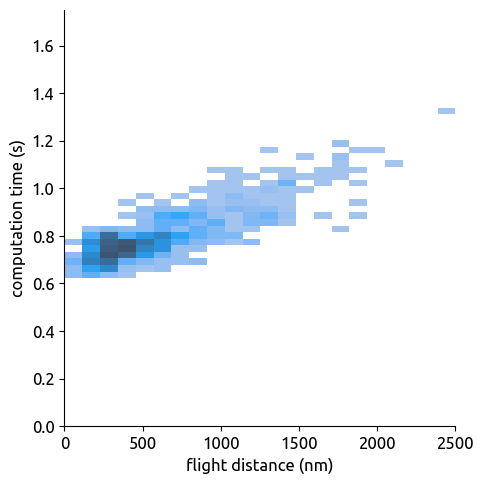

In [8]:
df = res.query("dist<3000")
sns.displot(df, x="dist", y="runtime")
plt.xlabel("flight distance (nm)")
plt.ylabel("computation time (s)")
plt.xlim(0, 2500)
plt.ylim(0, 1.75)

plt.tight_layout()
plt.savefig(
    f"../paper/figures/benchmark_flight.png",
    bbox_inches="tight",
    pad_inches=0,
    dpi=200,
)
plt.show()